In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from HRRR_URMA_Datasets import *
from SR_UNet_simple import *
from utils import *

torch.manual_seed(42)

In [2]:
# For comparison, need to be careful with datasets, 
# as the normalization differs, so models can only be compared on their OWN appropriately-normalized dataset!

In [3]:
BATCH_SIZE = 64 
NUM_EPOCHS = 2000

In [4]:
MONTHS_model_1 = [1,3]
DAYS_model_1 = [1,31] #make sure last entry matches number of days in month[1]...

MONTHS_model_2 = [1,3]
DAYS_model_2 = [1,31] #make sure last entry matches number of days in month[1]...

HOUR = 12  # 0 --> use only 00z data; 12 --> only 12z data

In [5]:
# Pay attention to details of terrain!
# These are bools, but write as ints for ease of string formatting later
# W_HRRR_T_model_1 = 1
# W_URMA_T_model_1 = 1
# W_DIFF_T_model_1 = 1

# W_HRRR_T_model_2 = 1
# W_URMA_T_model_2 = 0
# W_DIFF_T_model_2 = 1

In [6]:
#Loop over all possibilities

# idx = 66 #some random index
errors_list = []
spatial_errors_list = []
labels_list = []

for W_HRRR_T in [1, 0]:
    for W_URMA_T in [1, 0]:
        for W_DIFF_T in [1, 0]:
            pred_model_name = f"UNSim_BS{BATCH_SIZE}_NE{NUM_EPOCHS}_{str(HOUR).zfill(2)}z_months{MONTHS_model_1[0]}-{MONTHS_model_1[1]}_tHRRR{W_HRRR_T}_tURMA{W_URMA_T}_tDIFF{W_DIFF_T}"
            n_ch_in = 1+W_HRRR_T+W_URMA_T+W_DIFF_T

            train_ds = HRRR_URMA_Dataset_Anytime_Anydate_Anyterrain(is_train=True,
                                                                    with_hrrr_terrain=W_HRRR_T,
                                                                    with_urma_terrain=W_URMA_T,
                                                                    with_terrain_difference=W_DIFF_T,
                                                                    months=MONTHS_model_1,
                                                                    days=DAYS_model_1,
                                                                    hour=HOUR)

            pred_model = SR_UNet_simple(n_channels_in=n_ch_in)
            pred_model.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/hrrr_CNN_testing/Trained models/{pred_model_name}.pt", weights_only=True))
            device = "cuda:1"
            
            pred_model.to(device)

            tmp_error_list = []
            tmp_spatial_error_list = []
            for idx, (X,y) in enumerate(train_ds):
                X,y = train_ds[idx] 
                X = X[np.newaxis,:]
                X_gpu = torch.from_numpy(X).cuda(device)
                with torch.no_grad():
                    pred = pred_model(X_gpu)
                    pred = pred.cpu().numpy()
    
                y_unnormed = y.squeeze()*train_ds.urma_std + train_ds.urma_mean
                pred_unnormed = pred.squeeze()*train_ds.urma_std + train_ds.urma_mean

                tmp_spatial_error_list.append(pred_unnormed-y_unnormed)
                tmp_error_list.append((pred_unnormed-y_unnormed).flatten())

            spatial_errors_list.append(np.mean(tmp_spatial_error_list, axis=0))
            errors_list.append(np.array(tmp_error_list).flatten()) #(pred_unnormed-y_unnormed).flatten())
            labels_list.append(f"H{W_HRRR_T}/U{W_URMA_T}/D{W_DIFF_T}")
            print(f"H{W_HRRR_T}/U{W_URMA_T}/D{W_DIFF_T} DONE")
print("ALL DONE")

12z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
H1/U1/D1 DONE
12z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
H1/U1/D0 DONE
12z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
H1/U0/D1 DONE
12z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
H1/U0/D0 DONE
12z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
H0/U1/D1 DONE
12z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
H0/U1/D0 DONE
12z data selected
Done making date index list. Month

In [7]:
labels_with_quantiles = [label+f" \n 25%={np.quantile(errors_list[i], 0.25):.4f} \n 50% = {np.quantile(errors_list[i], 0.50):.4f} \n 75% = {np.quantile(errors_list[i], 0.75):.4f} \n Q3-Q1={(np.quantile(errors_list[i], 0.75)-np.quantile(errors_list[i], 0.25)):.4f}" for i, label in enumerate(labels_list)]

In [8]:
labels_with_quantiles

['H1/U1/D1 \n 25%=-0.1864 \n 50% = 0.0324 \n 75% = 0.2537 \n Q3-Q1=0.4401',
 'H1/U1/D0 \n 25%=-0.1967 \n 50% = 0.0237 \n 75% = 0.2948 \n Q3-Q1=0.4915',
 'H1/U0/D1 \n 25%=-0.2164 \n 50% = 0.0140 \n 75% = 0.2180 \n Q3-Q1=0.4344',
 'H1/U0/D0 \n 25%=-0.2953 \n 50% = -0.0115 \n 75% = 0.2312 \n Q3-Q1=0.5265',
 'H0/U1/D1 \n 25%=-0.3507 \n 50% = -0.1161 \n 75% = 0.1179 \n Q3-Q1=0.4686',
 'H0/U1/D0 \n 25%=-0.3522 \n 50% = -0.1019 \n 75% = 0.1187 \n Q3-Q1=0.4709',
 'H0/U0/D1 \n 25%=-0.2867 \n 50% = -0.0690 \n 75% = 0.1542 \n Q3-Q1=0.4409',
 'H0/U0/D0 \n 25%=-0.2104 \n 50% = 0.0464 \n 75% = 0.3018 \n Q3-Q1=0.5122']

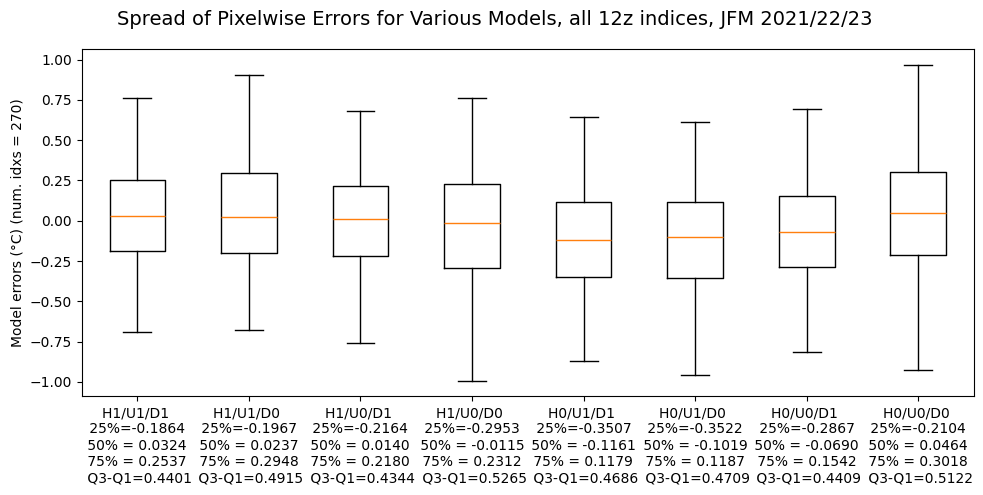

In [11]:
fig_hist, axes_hist = plt.subplots(1,1, figsize=(10,5))

bp = axes_hist.boxplot(errors_list, tick_labels=labels_with_quantiles, sym="", whis=(5,95))
plt.ylabel(f"Model errors (°C) (num. idxs = {idx+1})")# (idx={idx}) ")
plt.suptitle(f"Spread of Pixelwise Errors for Various Models, all {str(HOUR).zfill(2)}z indices, JFM 2021/22/23", fontsize=14)
plt.tight_layout()
plt.show()

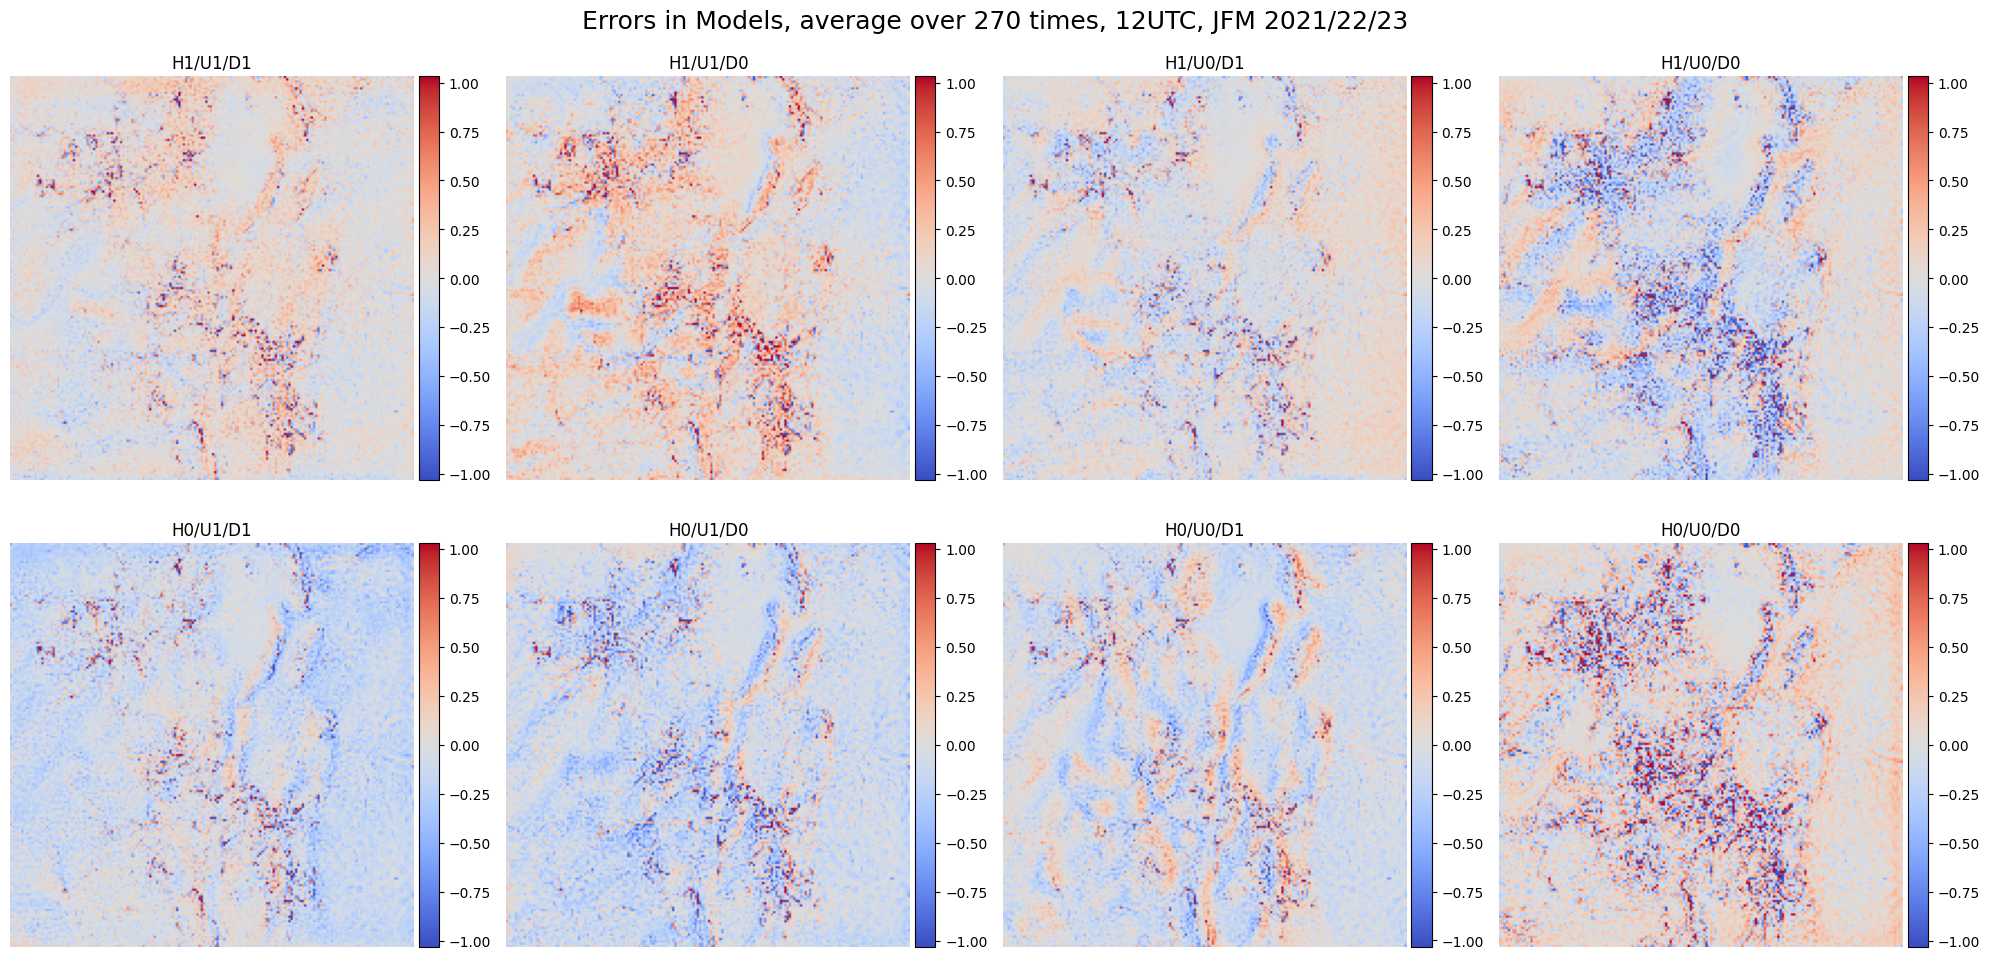

In [13]:
fig_sp_errs, ax_sp_errs = plt.subplots(2,4, figsize=(20,10))

mintemp = np.min(spatial_errors_list)
maxtemp = np.max(spatial_errors_list)
halfinterval = (maxtemp-mintemp)/7

n = 0
for i in [0,1]:
    for j in [0,1,2,3]:
        im = ax_sp_errs[i][j].imshow(spatial_errors_list[n], cmap="coolwarm", vmin=-1*halfinterval, vmax=halfinterval)
        divider = make_axes_locatable(ax_sp_errs[i][j])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax_sp_errs[i][j].axis("off")
        ax_sp_errs[i][j].set_title(labels_list[n])

        n+=1

plt.suptitle(f"Errors in Models, average over {idx+1} times, {str(HOUR).zfill(2)}UTC, JFM 2021/22/23", fontsize=18)
plt.tight_layout()
plt.show()